# Multilevel slopes

In [94]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

In [96]:
# Import multilevel model
multilevel_slopes = pystan.StanModel(file = '../src/models/multilevel_slopes.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2cc94c70c108a7a8e5f3cd9941c9d04 NOW.


In [78]:
data_check = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           beta_sd = 0.5, 
           run_estimation = 0)

fit_model_check = multilevel_slopes.sampling(data=data_check)
df_model_check = fit_model_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predcitive checks

In [79]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

fit_model_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

AttributeError: 'stanfit4anon_model_c42b01e8a46c5328de29922bdd2e33b' object has no attribute 'filter'

In [ ]:
az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

In [ ]:
## Fit model on fake data and recapture known parameters (appendix?)

In [ ]:
## Fit model on real data

In [97]:
data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           beta_sd = 0.5, 
           run_estimation = 1)

fit_model = multilevel_slopes.sampling(data=data)
df_model = fit_model.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


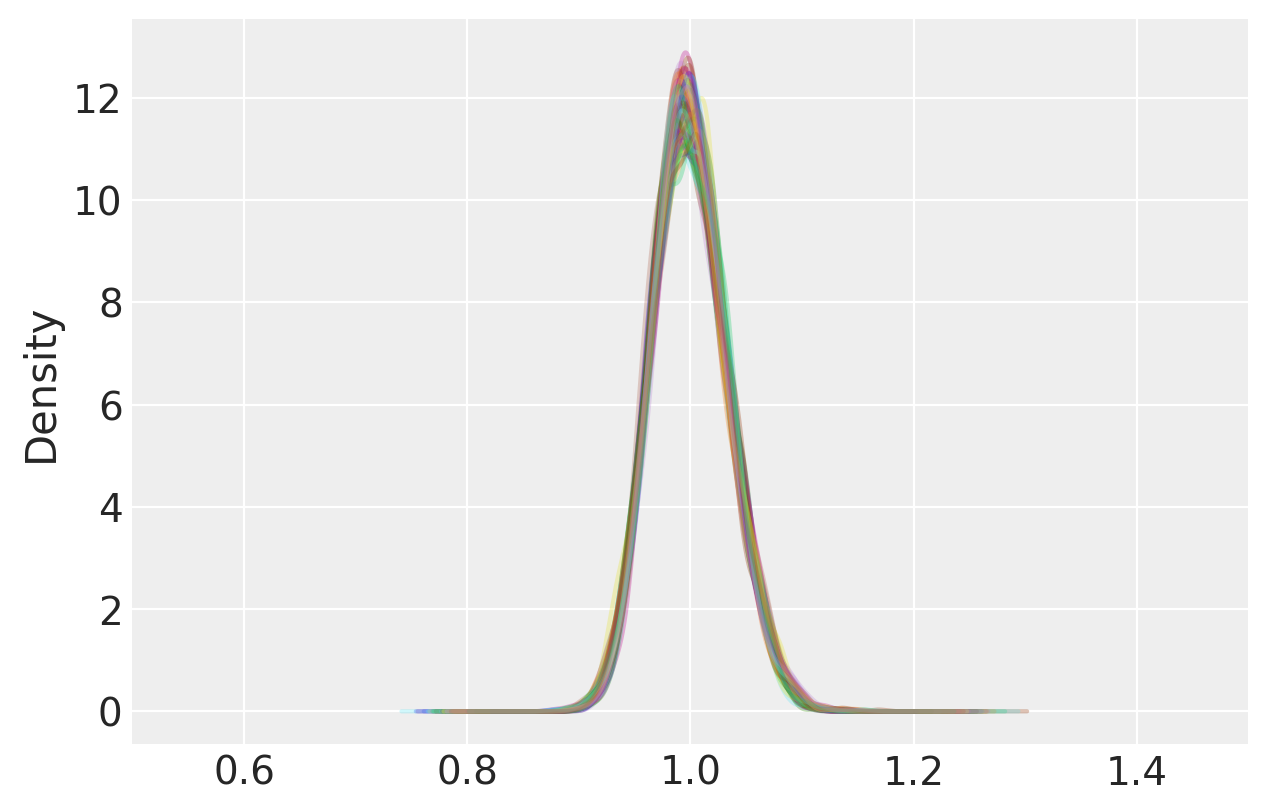

In [98]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

df_model.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (.5, 1.5));

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor


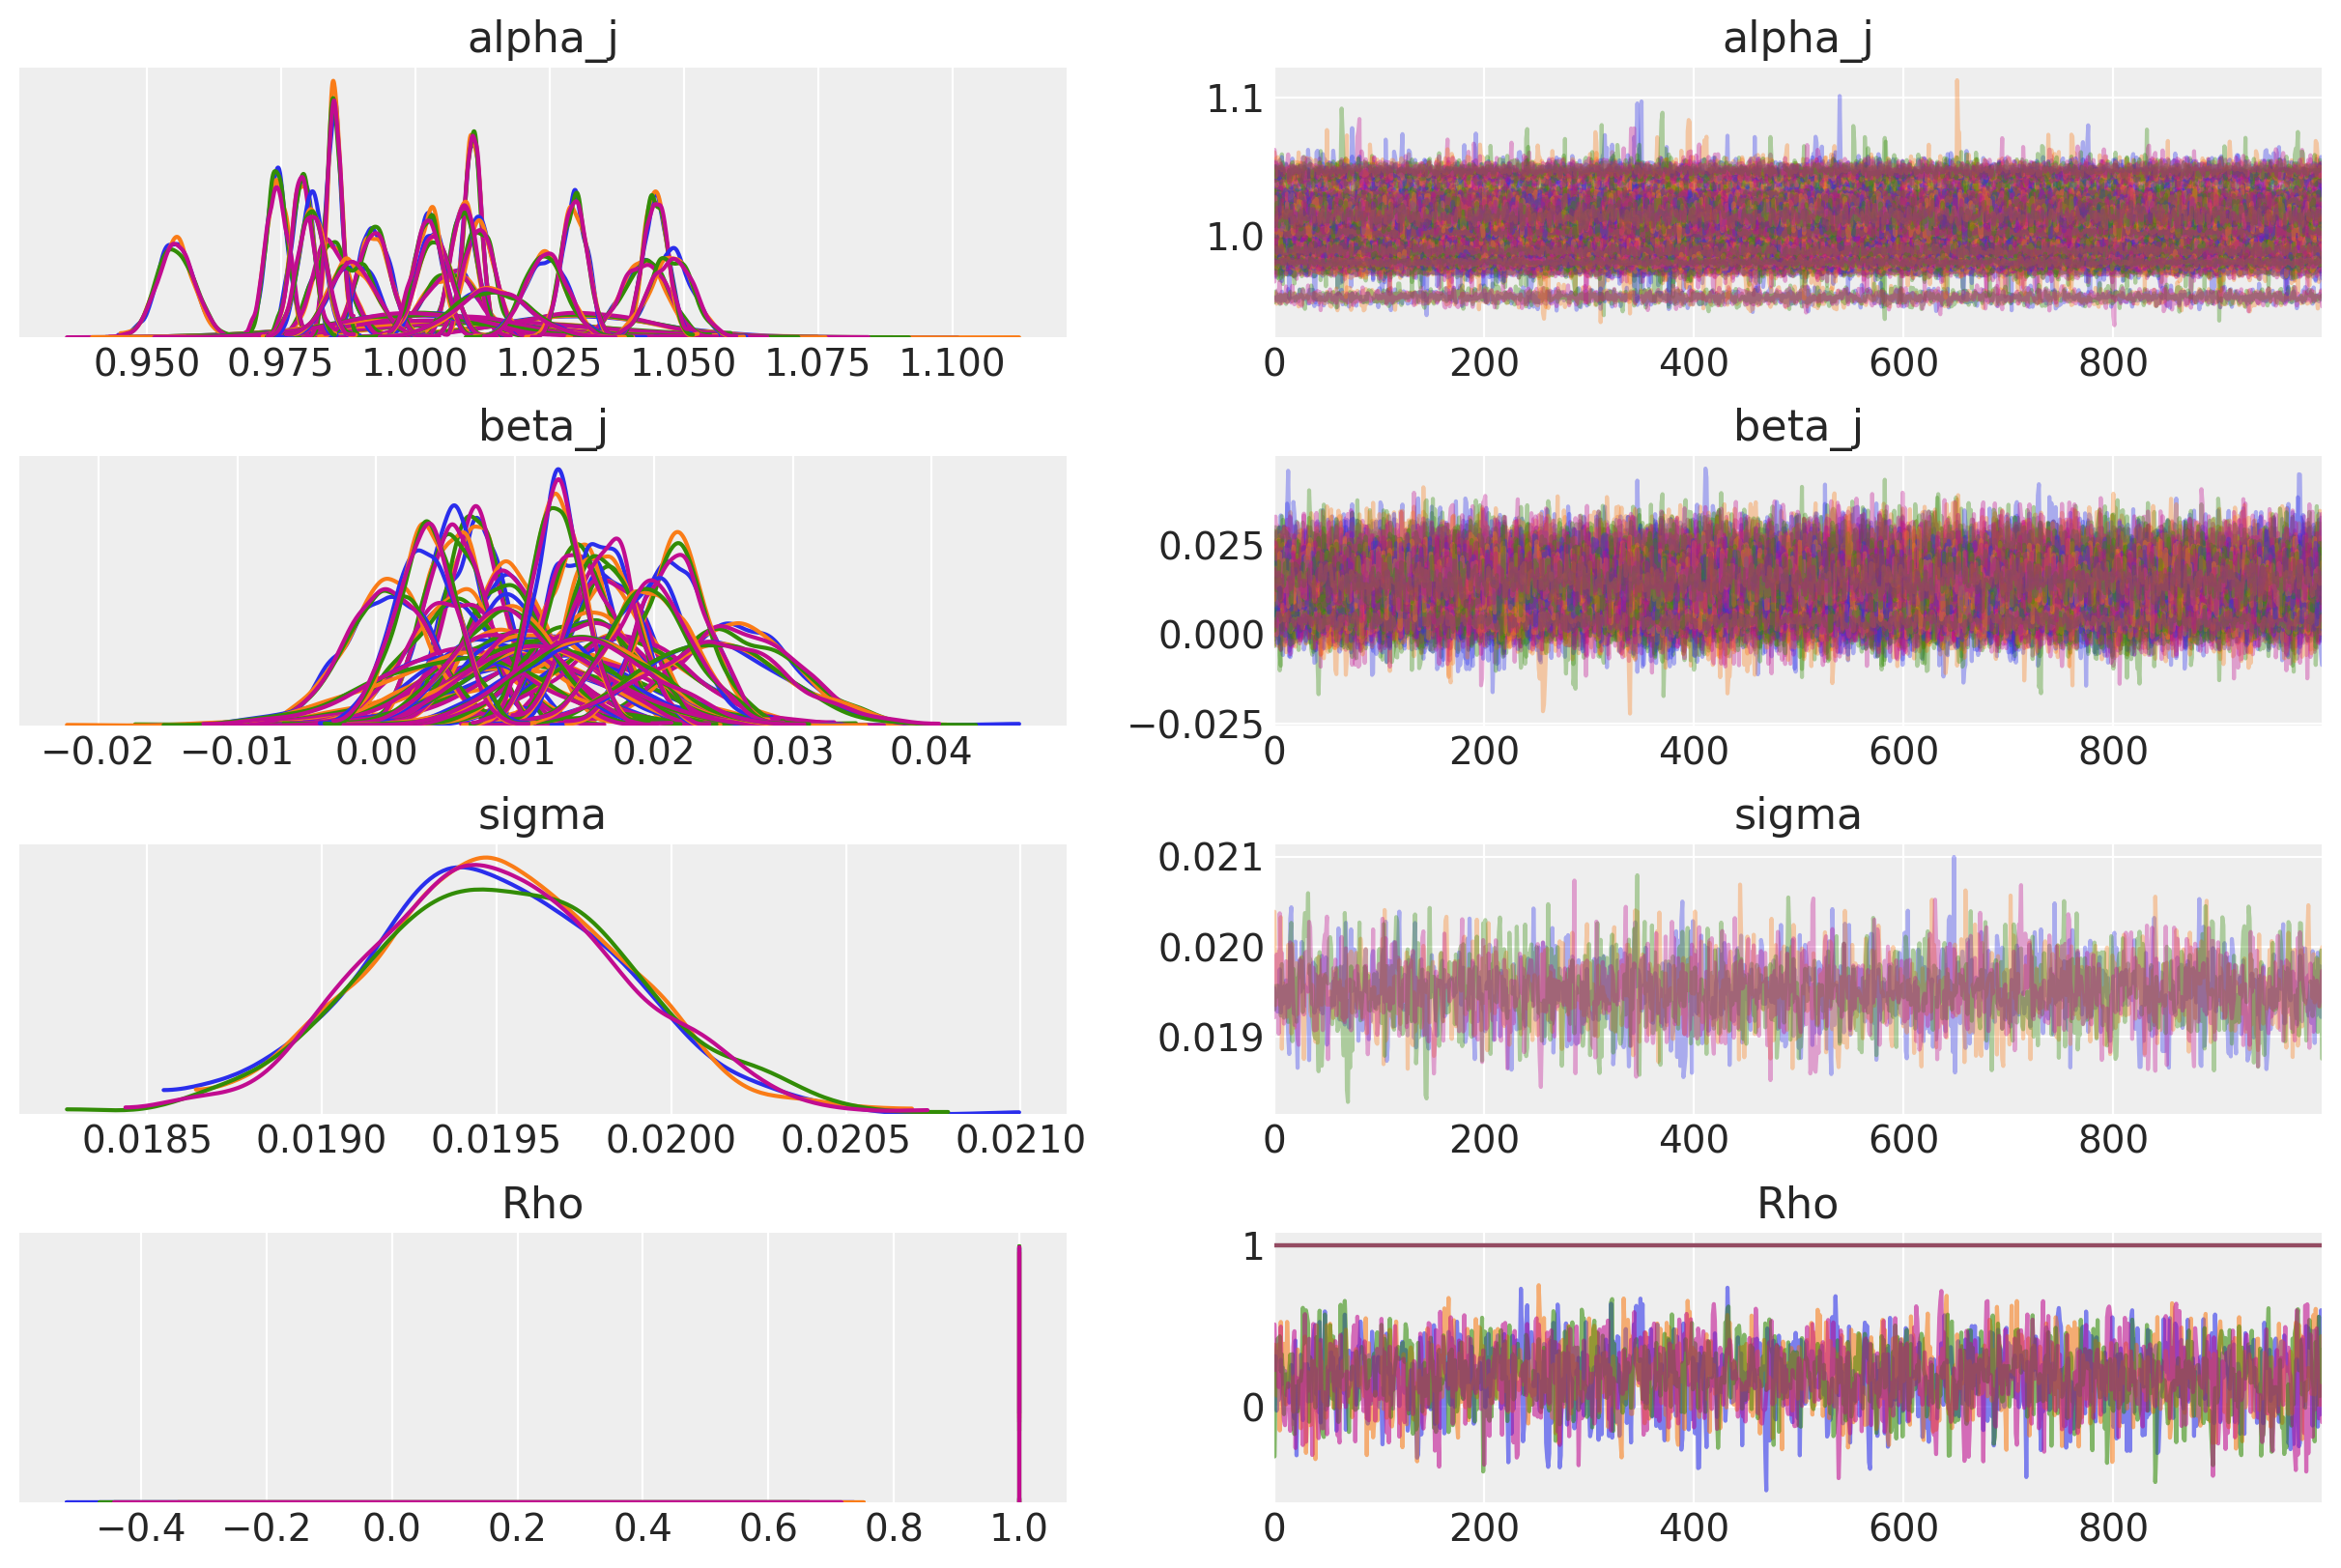

In [99]:
az.plot_trace(fit_model, var_names=["alpha_j", "beta_j", "sigma", "Rho"], compact = True);

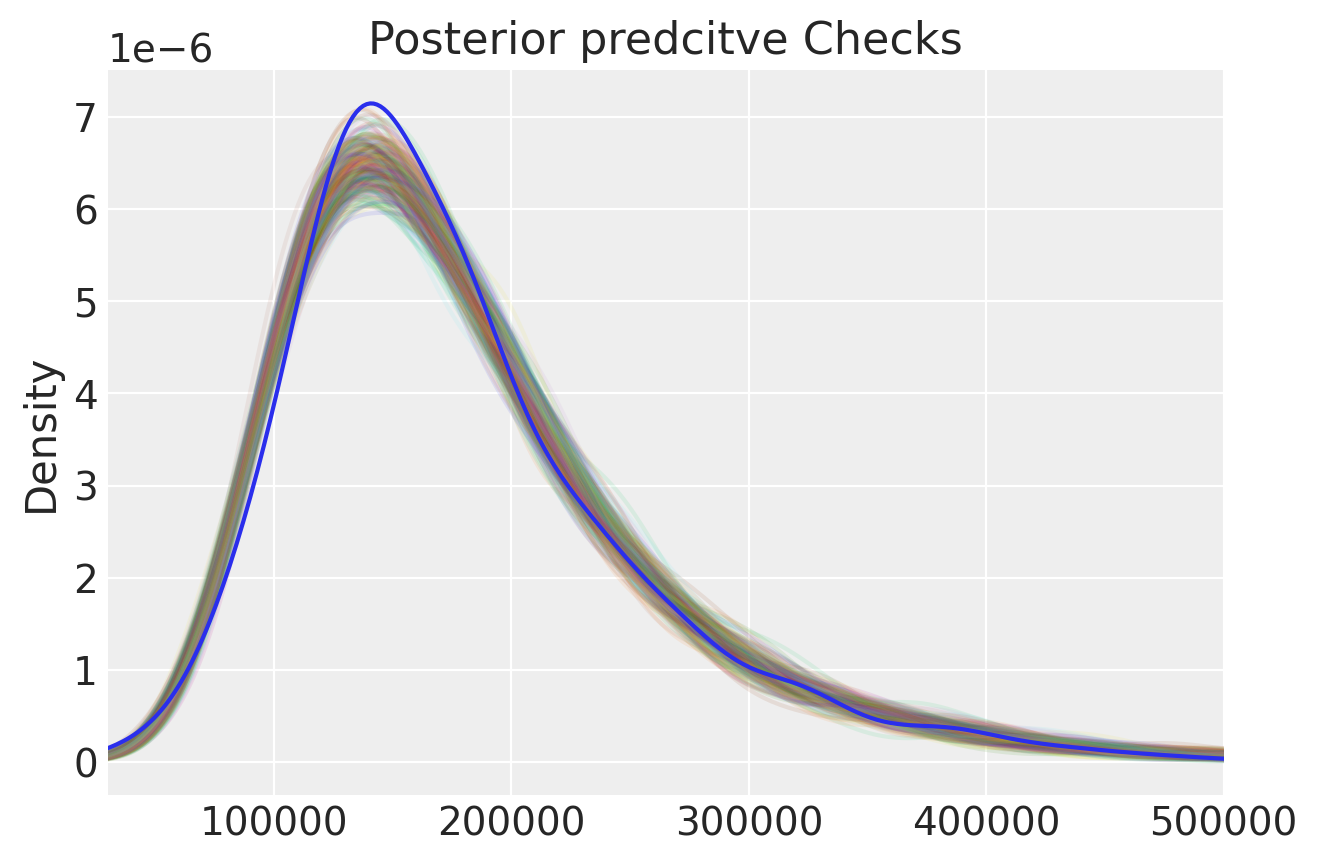

In [100]:
fig, axes = plt.subplots(1,1)
np.exp(df_model.filter(regex = 'y_hat')*train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predcitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);
train['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

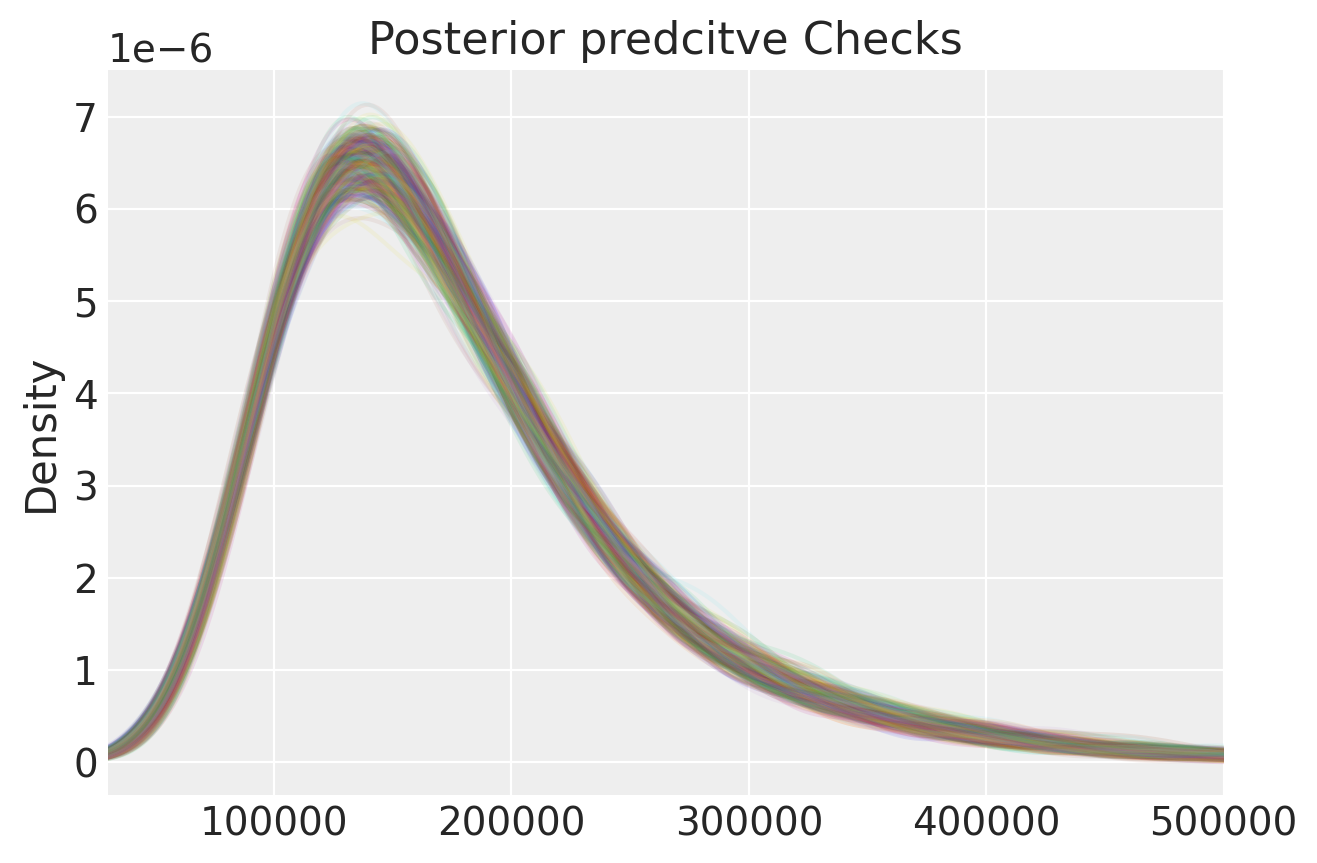

In [101]:
np.exp(df_model.filter(regex = 'y_test')*train['log_sales_price'].mean()).T.iloc[:, :500].plot.kde(legend = False, 
                                                                                                   title = 'Posterior predcitve Checks', 
                                                                                                   xlim = (30000,500000),
                                                                                                   alpha = 0.1);

In [105]:
predictions = pd.DataFrame(np.exp(df_model.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

multilevel_slope_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

multilevel_slope_csv.to_csv('../data/submissions/multilevel_slope.csv', index = False)

In [106]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f multilevel_slope.csv -m "multilevel slopes (fixed)"

Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:05<00:00, 6.49kB/s]
